#Modelo de clasificación: Procesado completo + Random Forest

Un primer acercamiento para la tarea de prediccion mediante un modelo de Random Forest. Se realiza un acercamiento experimental estableciendo unos parmétros adecuados y seleccionando el modelo al parecer más optimo, sin generar overfitting. Se realiza un procesamiento completo del dataset en el que el programa académico se categoriza en un área de conocimiento y se compara con el rendimiento que se obtiene frente a un procesamiento que ignora esta columna

##Instrucciones Generales

Para poder ejecutar el procesamiento propuesto, es necesario cargar tanto los archivos de la competencia de kaggle como el archivo de categorización manual de programas por área de conocimiento.

Para cargar los archivos de la competencia se puede:

1. Descargar directamente desde la página de kaggle: https://www.kaggle.com/competitions/udea-ai-4-eng-20251-pruebas-saber-pro-colombia/data y luego cargar manualmente al entorno

2. O ejecutar las celdas de carga directa utilizando una api-key propia de kaggle (archivo kaggle.json) que se debe cargar al entorno

Finalmente se debe cargar el archivo Categorias.csv que se ha enlazado en el repositorio github de esta solución para poder aplicar el procesamiento

##Importaciones básicas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
%matplotlib inline

##Preprocesado de los datos

###Carga de los datos

In [ ]:
!mkdir /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 934MB/s]
Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


###Creacion dataframe y su transformación

####Definición de las funciones de transformación

In [ ]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def create_dictionary_programs(programs_df):
  programs = {}
  for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
    if cat not in programs.keys():
      programs[cat] = [program]
    else:
      programs[cat].append(program)

  return programs

def add_knowledge_area_cols(df, programs):
  df_copy = df.copy()

  for area in programs.keys():
    column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
    df_copy = df_copy.join(column)

  other_column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =['OTRO'])
  df_copy = df_copy.join(other_column)

  return df_copy

def categorize_programs(df, programs):
  df_copy = df.copy()

  def assign_area(program):
    for area in programs.keys():
      if program in programs[area]:
        return area

    return 'OTRO'

  df_copy['AREA_TMP'] = df_copy['ESTU_PRGM_ACADEMICO'].apply(assign_area)

  for area in programs.keys():
      df_copy[area] = (df_copy['AREA_TMP'] == area).astype(int)

  df_copy['OTRO'] = (df_copy['AREA_TMP'] == 'OTRO').astype(int)
  df_copy = df_copy.drop(columns=['AREA_TMP'])

  return df_copy

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy


In [ ]:
def process_data_complete(df, programs_df):

  df_copy = df.copy()
  # drop ID column - repeated internet
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Areas de conocimiento - clasificación programas
  # creacion diccionario
  programs = create_dictionary_programs(programs_df)
  # creacion columnas
  df_copy = add_knowledge_area_cols(df_copy, programs)
  # categorizacion
  df_copy = categorize_programs(df_copy, programs)

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

In [ ]:
def process_data_incomplete(df):

  try:
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
  except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

  df_copy = df.copy()
  # drop ID column - repeated internet - programa
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  df_copy = df_copy.drop(columns=['ESTU_PRGM_ACADEMICO'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

####Dataframe resultante

In [ ]:
try:
  df = pd.read_csv("train.csv")
except:
  print("No se ha cargado el archivo train.csv al entorno")

In [ ]:
try:
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
    programs_df = programs_df.sample(frac=0.70, random_state=42)
    df = process_data_complete(df, programs_df)
    print(df.shape)
except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

/tmp/ipython-input-4-124035498.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(692500, 59)


In [ ]:
df_incomplete = pd.read_csv("train.csv")
df_incomplete = process_data_incomplete(df_incomplete)
print(df_incomplete.shape)

/tmp/ipython-input-4-124035498.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(692500, 48)


###Separación de los datos

In [ ]:
X = df.drop(columns=['RENDIMIENTO_GLOBAL', 'ESTU_PRGM_ACADEMICO'])
y = df['RENDIMIENTO_GLOBAL']
print(X.shape)
print(y.shape)

(692500, 57)
(692500,)


##Creación y evaluacion del modelo

###Split de los datos train: 70% - test: 30%

In [ ]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3)

###Modelo y calibración

In [ ]:
estimators = [1, 2, 5, 8, 10, 20, 50]
depths = [2, 5, 8, 10, 12]

max_acc = 0
n_estimators = 0
max_depth = 0

for i in estimators:
  for j in depths:

    rf = RandomForestClassifier(n_estimators=i, max_depth=j)
    rf.fit(Xtr,ytr)
    acc_tr = rf.score(Xtr,ytr)
    acc_ts = rf.score(Xts,yts)

    if acc_ts > max_acc:
      max_acc = acc_ts
      n_estimators = i
      max_depth = j

    print (f"model with {i} estimators with {j} max depth, train accuracy: {acc_tr:6f}, test accuracy: {acc_ts:6f}")


model with 1 estimators with 2 max depth, train accuracy: 0.284130, test accuracy: 0.282325
model with 1 estimators with 5 max depth, train accuracy: 0.335204, test accuracy: 0.332515
model with 1 estimators with 8 max depth, train accuracy: 0.370504, test accuracy: 0.367422
model with 1 estimators with 10 max depth, train accuracy: 0.377522, test accuracy: 0.372072
model with 1 estimators with 12 max depth, train accuracy: 0.390191, test accuracy: 0.376890
model with 2 estimators with 2 max depth, train accuracy: 0.341999, test accuracy: 0.339620
model with 2 estimators with 5 max depth, train accuracy: 0.365603, test accuracy: 0.364221
model with 2 estimators with 8 max depth, train accuracy: 0.375076, test accuracy: 0.372452
model with 2 estimators with 10 max depth, train accuracy: 0.389147, test accuracy: 0.380626
model with 2 estimators with 12 max depth, train accuracy: 0.391988, test accuracy: 0.375591
model with 5 estimators with 2 max depth, train accuracy: 0.353366, test acc

In [ ]:
print(f"best model with {n_estimators} estimators with {max_depth} max depth")

best model with 50 estimators with 12 max depth


El uso de 50 estimadores pero con una profundidad máxima de 10 parece ser una opción más acertada pues a mayor profundidad parece que empieza a presentarse sobre ajuste. Se prueba si el uso de más estimadores con esta profundidad mantiene un buen balance entre el desempeño de entrenamiento y de test

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(Xtr,ytr)
acc_tr = rf.score(Xtr,ytr)
acc_ts = rf.score(Xts,yts)
print (f"train accuracy: {acc_tr:6f}, test accuracy: {acc_ts:6f}")

train accuracy: 0.408588, test accuracy: 0.396106


Comparando los diferentes resultados es mejor un modelo con 50 estimadores

###Validación cruzada

In [ ]:
def bootstrap_score(X, y, test_size, iterations=5, n_estimators=50):
  trscores, tsscores = [], []
  for _ in range(iterations):
    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=10)
    rf.fit(Xtr,ytr)
    trscores.append(rf.score(Xtr, ytr))
    tsscores.append(rf.score(Xts, yts))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

def evaluate_model(df, test_size, n_estimators=50):
  sample_sizes = [int(i*df.shape[0]) for i in np.linspace(0.2, 1, 5)]
  tr_scores, ts_scores = [], []

  for sample_size in sample_sizes:
    X = df.sample(sample_size)
    y = X['RENDIMIENTO_GLOBAL']
    X = X.drop(columns=['RENDIMIENTO_GLOBAL', 'ESTU_PRGM_ACADEMICO'])
    tr_sc, ts_sc = bootstrap_score(X, y, test_size, iterations=3, n_estimators=n_estimators)
    tr_scores.append(tr_sc)
    ts_scores.append(ts_sc)

  return (tr_scores, ts_scores)

def plot_learning_curve(title, train_scores_mean, train_scores_std,
                        test_scores_mean, test_scores_std, ylim=None,
                        train_sizes=np.linspace(.2, 1.0, 5)):

    from matplotlib import pyplot as plt

    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training samples")
    plt.ylabel("Score")

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="test score")

    plt.legend(loc="best")

def compute_and_plot_learning_curve(test_size, n_estimators=50, title="Random Forest"):

    learn_curve_data = evaluate_model(df, 0.3, n_estimators)
    tr_means = np.array([learn_curve_data[0][i][0] for i in range(len(learn_curve_data[0]))])
    tr_stds = np.array([learn_curve_data[0][i][1] for i in range(len(learn_curve_data[0]))])
    ts_means = np.array([learn_curve_data[1][i][0] for i in range(len(learn_curve_data[1]))])
    ts_stds = np.array([learn_curve_data[1][i][1] for i in range(len(learn_curve_data[1]))])

    sample_sizes = [int(i*df.shape[0]) for i in np.linspace(0.2, 1, 5)]

    plot_learning_curve(title, tr_means, tr_stds, ts_means, ts_stds, train_sizes=sample_sizes)

In [ ]:
tr_sc, ts_sc = bootstrap_score(X, y, 0.3)
print(f"Train accuracy {tr_sc[0]:6f} ± {tr_sc[1]:6f}, test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")

Train accuracy 0.408785 ± 0.001120, test accuracy: 0.396523 ± 0.000780


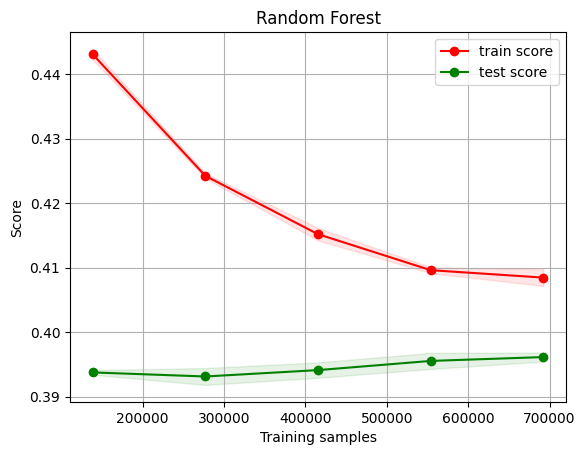

In [ ]:
compute_and_plot_learning_curve(0.30)

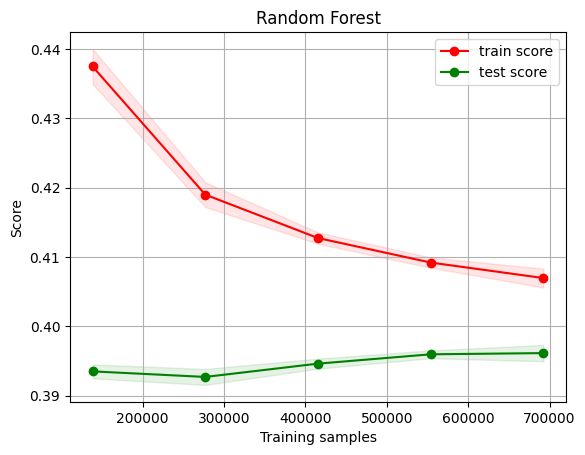

In [ ]:
compute_and_plot_learning_curve(0.30, n_estimators=20)

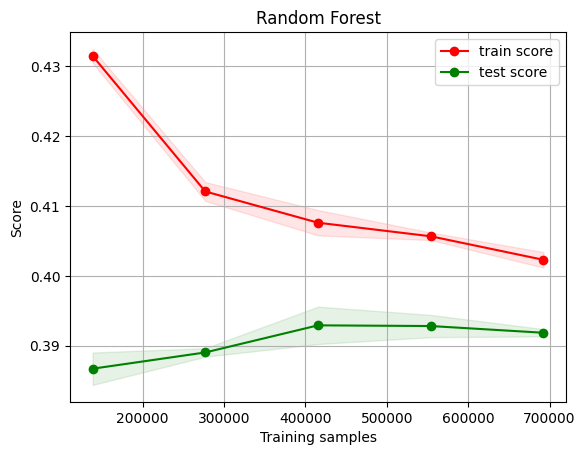

In [ ]:
compute_and_plot_learning_curve(0.30, n_estimators=10)

Aun con menos estimadores, las curvas de aprendizaje tienden a ser similares y no se alcanza la convergencia en rendimiento. Se elige el modelo con 50 estimadores por ser el que ofrece mejor porcentaje de acierto

###Modelo sobre procesado incompleto

In [ ]:
X_inc = df_incomplete.drop(columns=['RENDIMIENTO_GLOBAL'])
y_inc = df_incomplete['RENDIMIENTO_GLOBAL']
print(X.shape)

(692500, 57)


In [ ]:
Xtr_in, Xts_in, ytr_in, yts_in = train_test_split(X_inc,y_inc, test_size=0.3)

In [ ]:
rf = RandomForestClassifier(n_estimators=50, max_depth=10)
rf.fit(Xtr_in,ytr_in)
acc_tr = rf.score(Xtr_in,ytr_in)
acc_ts = rf.score(Xts_in,yts_in)
print (f"train accuracy: {acc_tr:6f}, test accuracy: {acc_ts:6f}")

train accuracy: 0.403020, test accuracy: 0.390917


In [ ]:
tr_sc, ts_sc = bootstrap_score(X_inc, y_inc, 0.3)
print(f"Train accuracy {tr_sc[0]:6f} ± {tr_sc[1]:6f}, test accuracy: {ts_sc[0]:6f} ± {ts_sc[1]:6f}")

Train accuracy 0.403074 ± 0.000580, test accuracy: 0.391141 ± 0.002062


El ignorar la clasificación de programas baja el desempeño del modelo aunque lo hace ligeramente. Igualmente se continuará el análisis evaluando la clasificación del programa académico en las distintas áreas de conocimiento y otras posibles técnicas

###Calibración con todo el conjunto de datos

In [ ]:
rf = RandomForestClassifier(n_estimators=50, max_depth=10)
rf.fit(X,y)

RandomForestClassifier(max_depth=10, n_estimators=50)

##Predicción

In [ ]:
test_df = pd.read_csv("test.csv")
print(test_df.shape)
test_df_processed = process_data_complete(test_df, programs_df)
print(test_df_processed.shape)

(296786, 20)


/tmp/ipython-input-4-124035498.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


(296786, 58)


In [ ]:
test_df_processed = test_df_processed.drop(columns = ['ESTU_PRGM_ACADEMICO'])
y_pred = rf.predict(test_df_processed)

###Dataframe de predicción

In [ ]:
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
y_pred = pd.DataFrame(y_pred, columns=['RENDIMIENTO_GLOBAL'])
y_pred = y_pred.replace(dict(zip(range(4), grades)))
y_pred.head()
prediction_df = pd.concat([test_df['ID'], y_pred], axis=1).set_index('ID')
print(prediction_df.shape)
prediction_df.head()

(296786, 1)


,RENDIMIENTO_GLOBAL
ID,
550236,alto
98545,medio-alto
499179,alto
782980,bajo
785185,bajo


###Exportando el archivo

In [ ]:
prediction_df.to_csv("submission.csv")